Kimberly Devi Milner

EE Independent Study w/  Fraida Fund

# Radio Machine Learning: Modeling the presence of a primary user as a  classification problem


# Theretical Background
**ATTRIBUTION:** Images and references from https://ctvrie.files.wordpress.com/2013/07/cograd_commtheory_2013.pdf

### What is a cognitive radio?
A cognitive radio is a radio that is aware of its environemnt. 

Cognitive radios (CR) can dynamically and autonomously adjust radio parameters to interact with the environment around it. In this way CRs can decide the optimal carrier frequency and bandwidth to guide the signal to its end to end communication. 

### Why do we need cognitive radios?
CISCO foresees a x1000 increase in wireless traffic by 2020. The licensed and unlicensed spectrum cannot grow at this rate. 

Cognitive radios provide several solutions to this dilemma; one including a mechanism to take advantage of spectrum holes -- a point in frequency, time or space -- which is not occupied by any transmission. 

### How  could Cognitive Radios work?

#### Spectrum Awareness
The cognitive/secondary radio can learn about its environment by observing characteristics of the primary uers's channel. These characteristics include:
    * Traffic Patterns
    * Signaling Procedures
    * Channel Conditions
    * (parts of) messages sent by the legacy system


#### Transmitting the Secondary Signal

There are 3 protocols for the secondary user to transmit signals, which break down into "margin" operations and "help" operations.


###### Image References
> * P/STX = primary/secondary transmitter
> * P/SRX = primary/secondary receiver

$$MARGIN:$$
** Underlaying: ** The secondary user's interference to the licensed user's is not avoided, but controlled. The secondary user's intereference should go below the noise floor.
> The difficulty here is due to the fact that the exact interference situation at the primary receiver is not known.

<img src="interweave_2.png">  

** Interleaving: ** Interference by the secondary user is avoided and the secondary user seeks  opportunistic/orthogonal transmission through spectrum holes.
<img src="underlay.png">

$$HELP:$$
** Overlaying: ** The Cognitive Radio knows much more about the primary system (like what message it is sending) and can possibly retransmit this message. 
<img src="overlay.png"> 




# How can we effectively detect whether or not there is another user present on the spectrum that we want to use?

**REFERENCES:** (chapter 2 of Cognitive Radio Book)

*Biglieri, E., Goldsmith, A.J., Greenstein, L.J., Mandayam, N.B. and Poor, H.V. (2012) ‘Capacity of cognitive radio networks’, in Principles of Cognitive Radio:. Cambridge: Cambridge University Press, pp. 41–101.*


## What is  energy sensing 

**Energy sensing**  tries to determine the presence of a spectrum hole by comparing the measured energy of the primary channel against a threshold set for primary-user-presence.

The primary-user-presence "threshold depends on the observed-signal model and hence on the noise variance" (157).
So an error made in the estimation of the noise variance will degrade the performance of an engergy detector.

But as the energy detector cannot discriminate between signal and noise, it is more likely to make errors in estimating noise variance, especially at low SNRs, and perform worse.
 
## What is Signal-to-Noise Ratio (SNR),  also known as channel gain?
$$SNR= \frac{signalPower}{noisePower}$$ 


Channel gain is the amplification or attenuation of a signal on a channel:

Channel gain(H) for channel(S,R)  is: $$Y = HX + Z(noise),$$ where Y is the  signal received.



# Loading an AWGN PSK signal generated on GNU radio 
<img src="inp_vs_noise_vs_output.png">

In [162]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os, re, glob
from scipy import stats




## Scatter Plot Of Average Power per SNR

## The Density Plot of Average Power

In [ ]:
def plot_density(noise_power, noisy_signal_power, ax=None,title="title"):
    if ax is None:
        ax = plt.gca()
    signal_power_density = stats.kde.gaussian_kde( np.array(noisy_signal_power) )
    noise_power_density = stats.kde.gaussian_kde( np.array(noise_power) )
    
    x = np.arange(0., 1.2*max(noisy_signal_power), 1e-6)

    bp = ax.plot(x, signal_power_density(x))
    bp = ax.plot(x, noise_power_density(x), color='r')
    bp = ax.set_title(title)
    bp = ax.set_xlim([0,max(x)])
    bp = ax.set_xlabel("Power (linear)")
    bp =ax.set_ylabel("Frequency")
    bp = ax.legend(['output signal','noise'],  loc="upper right")
    bp = ax.locator_params(nbins=4)

    return bp
    
   

In [164]:
def compute_power(arr):  
    # used to compute power of signal and Power of Noise
    return sum([ np.abs(i)**2 for i in arr])/len(arr)

# GLOBALS
ntrials=128 
no_files_per_snr= 1  #CHANGE BACK


def plot_avg_pwr(noise_power, noisy_signal_power, ax,  title="title"):
        # plot avg power for noisy signal and nosie for pickled files of a specified db
        ax.scatter(noisy_signal_power,range(len(noisy_signal_power)), alpha=0.2)
        ax.scatter(noise_power,range(len(noise_power)), color="r", alpha=0.2)
        ax.set_xlabel("Power (linear scale)")
        ax.set_ylabel("Sample number ")
        ax.legend(['output signal','noise'],  loc="upper right")
        ax.set_title(title)
        ax.set_xlim([0,max(noisy_signal_power)])
        ax.set_ylim([0,max(range(len(noisy_signal_power)))])
        ax.locator_params(nbins=4)
        


for snr_desired in [-3]:          # CHANGE BACK
    
    # Get lists of sample files for the given SNR and read in the samples into array
    noise_files = [file for file in glob.glob("samples/samples_" + ("%.1f" % snr_desired) + "*noise.npy")]
    sn_files = [file for file in glob.glob("samples/samples_" + ("%.1f" % snr_desired) + "*sn.npy")]
    noise_power_array = [compute_power(j) for f in noise_files for i,j, in enumerate(np.load(f))]
    sn_power_array = [compute_power(j) for f in sn_files for i,j, in enumerate(np.load(f))]
    
    
    # Read in data for experiments where we save just ndata=128 samples
    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_128" + "*noise.npy"
    noise_files_128 = [file for file in glob.glob(noise_pattern)]
    noise_power_128 = [compute_power(j) for f in noise_files_128 for i,j, in enumerate(np.load(f))]

    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_128" + "*sn.npy"
    sn_files_128 = [file for file in glob.glob(sn_pattern)]
    sn_power_128 = [compute_power(j) for f in sn_files_128 for i,j, in enumerate(np.load(f))]
    

In [163]:
    
plot_density(noise_power_128, sn_power_128, ax1, title = "%.1f dB" % snr_desired)
plot_avg_pwr(noise_power_array, sn_power_array, ax2, title = "%.1f dB" % snr_desired)
plt.tight_layout()


ValueError: max() arg is an empty sequence

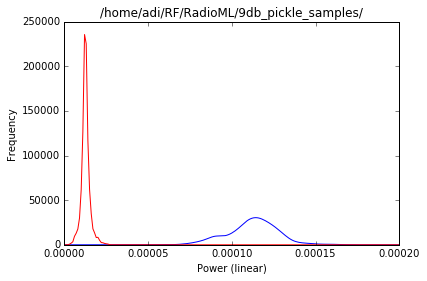

In [271]:
plot_density(path)

/home/adi/RF/RadioML/9db_pickle_samples/


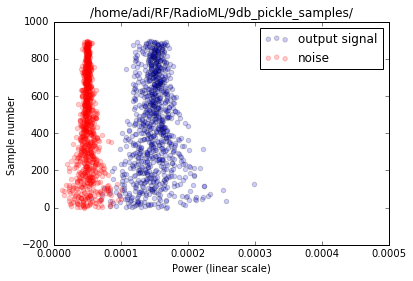

In [282]:
path = "/home/adi/RF/RadioML/3db_pickle_samples/"
files = get_specific_snr_dir(path)
create_array_of_signal_power(files,ntrials,no_files_per_snr,path)        
plot_avg_pwr(files)

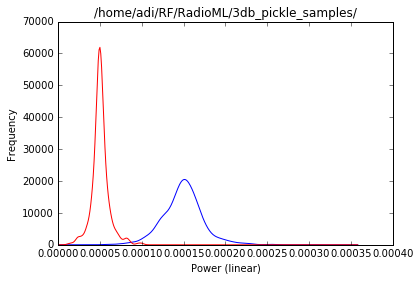

In [263]:
plot_density(path)

/home/adi/RF/RadioML/9db_pickle_samples/


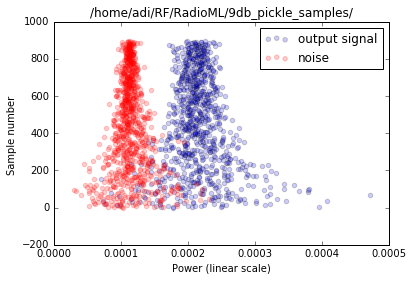

In [286]:
path = "/home/adi/RF/RadioML/neg0db_pickle_samples/"
files = get_specific_snr_dir(path)
create_array_of_signal_power(files,ntrials,no_files_per_snr,path)        
plot_avg_pwr(files,path)

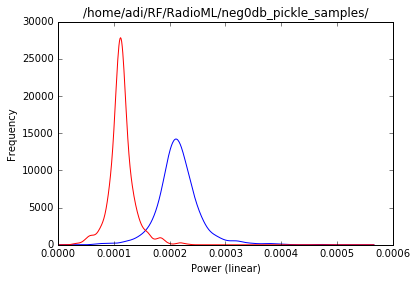

In [267]:
plot_density(path)

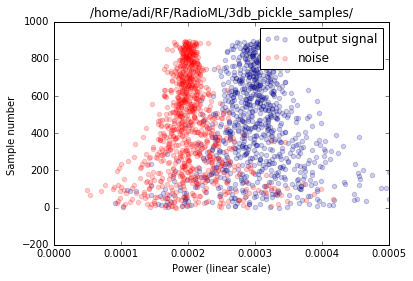

In [268]:
path = "/home/adi/RF/RadioML/neg3db_pickle_samples/"
files = get_specific_snr_dir(path)
create_array_of_signal_power(files,ntrials,no_files_per_snr)        
plot_avg_pwr(files)

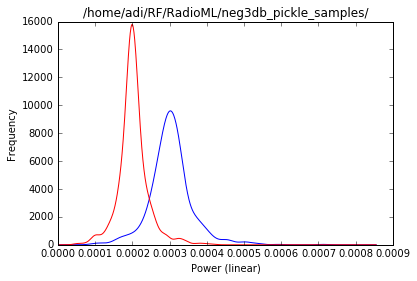

In [269]:
plot_density(path)

In [ ]:
#path= "/home/adi/RF/RadioML/pickled_samples_128_trials/"
files = [os.path.join(path,"3db_64samples_of_signal.p"),
         os.path.join(path,"3db_128samples_of_signal.p"),
         os.path.join(path,"3db_256samples_of_signal.p"),
        os.path.join(path,"3db_512samples_of_signal.p"),
         os.path.join(path,"3db_1024samples_of_signal.p"),
          os.path.join(path,"3db_2048samples_of_signal.p"),
         os.path.join(path,"3db_4096samples_of_signal.p")]


for j,fn in enumerate(files):  
        # unpack pickled files
        P = open(fn, "rb")
        
        signal_matrix, noise_matrix, signal_and_noise_matrix = pickle.load(P, encoding="latin-1")
        print(signal_matrix.T[1])
        print("shape is", len(signal_matrix[1]))
    #apply function passing in arrays
        for i in range(j*ntrials, ntrials -1+ j*ntrials):
            noisy_signal_power[0] =compute_power(signal_and_noise_matrix.T[i])
            noise_power[i]= compute_power(noise_matrix.T[i])
    

In [95]:
noisy_signal_power =np.ones(shape=( 128,64), dtype=float)

noisy_signal_power[120][2]

1.0

In [86]:
print(files)

['/home/adi/RF/RadioML/pickled_samples_128_trials/3db_64samples_of_signal.p']


In [71]:
for j,fn in enumerate(files):
    print(j,fn)

0 /home/adi/RF/RadioML/pickled_samples_128_trials/3db_64samples_of_signal.p


In [51]:
for fn in files:  
        # unpack pickled files
        P = open(fn, "rb")
        signal_matrix, noise_matrix, signal_and_noise_matrix = pickle.load(P, encoding="latin-1")
        break
len(signal_matrix[1])
print(signal_matrix[1])
print(compute_power(signal_matrix)[1])
print(noisy_signal_power[0])

[ -1.85851168e-04 +1.02274716e-02j   1.34945549e-05 +9.97849181e-03j
  -1.04262726e-05 +9.90714133e-03j   0.00000000e+00 +1.01462509e-02j
   1.04262735e-05 +9.90714133e-03j  -1.34945494e-05 +9.97849181e-03j
   1.68473009e-04 +1.02100940e-02j  -2.39117144e-04 +9.73279588e-03j
  -4.04635241e-04 +9.63698514e-03j   1.08474400e-03 +1.10767288e-02j
   5.32516395e-04 +1.04292314e-02j  -5.07312547e-03 +5.07312547e-03j
  -1.04396576e-02 -5.22090122e-04j  -1.10632349e-02 -1.09823840e-03j
  -9.82283708e-03 +5.55730134e-04j  -9.47526749e-03 +1.84109249e-05j
  -9.82120354e-03 -5.88853261e-04j  -1.10654412e-02 +1.09603221e-03j
  -1.04312394e-02 +5.30508056e-04j  -5.08047547e-03 -5.08047640e-03j
   5.10067912e-04 -1.04516791e-02j   1.11658464e-03 -1.10448897e-02j
  -4.12316265e-04 -9.67942178e-03j  -2.63238995e-04 -9.72009543e-03j
   2.17760069e-04 -1.01922955e-02j  -4.45142759e-05 -1.00139230e-02j
  -3.95129973e-05 -9.94024519e-03j   9.04480476e-05 -1.00705037e-02j
  -4.99392772e-05 -9.99155175e-03j

In [6]:
pattern = '3db_64samples_of_signal.p'

path= "/home/adi/RF/RadioML/pickled_samples_128_trials/"
fn=path+"3db_64samples_of_signal.p"
#files_=[fn]
for i in os.wa: print(i)
print (fn)

/home/adi/RF/RadioML/pickled_samples_128_trials/3db_64samples_of_signal.p


In [7]:
pwd

'/home/adi/RF/RadioML'

In [28]:
x = re.match(pattern,fn)
x

In [26]:
help(re.match)

Help on function match in module re:

match(pattern, string, flags=0)
    Try to apply the pattern at the start of the string, returning
    a match object, or None if no match was found.



In [45]:
compute_power(signal_matrix[100])

0.00010007983236128316

In [2]:
signal, noise, signal_and_noise = pickle.load("pickled_samples_128_trials/neg3db_1024samples_of_signal.p")
# PSKModem lifted from CommPy:
# https://github.com/veeresht/CommPy/blob/master/commpy/modulation.py#L97

txpower = 1
freq = 1
m = 4
num_bits_symbol = int(np.log2(m))
symbol_mapping = np.arange(m)
def psk_constellation_symbol(i):
    return np.cos(2*np.pi*(i-1)/m) + np.sin(2*np.pi*(i-1)/m)*(0+1j)

constellation = [psk_constellation_symbol(sym) for sym in symbol_mapping]

print(constellation)

samples_per_symbol=64

samples=2*np.pi*np.arange(samples_per_symbol)/samples_per_symbol

nbits = 23 # *samples/sym elements in final array

bitstream = np.random.randint(0,4,nbits)
    #print(constellation)

sstream = []
for bit in bitstream:
    symbol = constellation[bit]
    magnitude = np.abs(symbol)
    phase = np.angle(symbol)
    sstream.append(magnitude*np.sin(samples*freq + phase))    
 
x = np.arange(nbits*samples_per_symbol)

input_signal = txpower*np.ndarray.flatten(np.array(sstream))

print(input_signal)


[(6.123233995736766e-17-1j), (1+0j), (6.123233995736766e-17+1j), (-1+1.2246467991473532e-16j)]
[-1.         -0.99518473 -0.98078528 ..., -0.95694034 -0.98078528
 -0.99518473]


[-0.2936524  -1.13380481 -1.06501181 ..., -0.50826621 -0.40533806
 -0.69513227]
The signal power is  0.782663422941
The noise power is  0.254458631215
The SNR is 3.07579829068


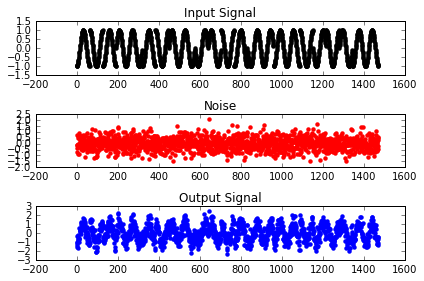

In [3]:

# AWGN channel also lifted from CommPy
# https://github.com/veeresht/CommPy/blob/master/commpy/channels.py#L72
snr_dB = 3
avg_energy = sum(np.abs(input_signal) * np.abs(input_signal))/len(input_signal)
snr_linear = 10**(snr_dB/10.0)
noise_variance = avg_energy/(2*snr_linear)   
# http://www.rapidtables.com/electric/decibel.htm#power_db
# Notice that amplitude ration is different from power ratio by a factor of 2
#noise_variance = avg_energy/(snr_linear)

if input_signal.dtype == complex:
    noise = (np.sqrt(noise_variance) * np.random.randn(len(input_signal)))  \
    + (np.sqrt(noise_variance) * np.random.randn(len(input_signal))*1j)
else:
    noise = np.sqrt(2*noise_variance) * np.random.randn(len(input_signal))

output_signal = input_signal + noise
print(output_signal)
# Power of signal and Power of Noise
signal_P = sum([ np.abs(i**2) for i in output_signal])/len(output_signal)
noise_P = sum([ np.abs(i**2) for i in noise]) / len(noise)
print("The signal power is ", signal_P)
print("The noise power is ", noise_P)
print("The SNR is" ,signal_P/noise_P)

plt.subplot(311)
plt.scatter(x,input_signal, color='k',linewidth=".001")
plt.title("Input Signal")
plt.tight_layout()

plt.subplot(312)
plt.scatter(x,noise, color='r',linewidth=".001")
plt.title("Noise")
plt.tight_layout()

plt.subplot(313)
plt.scatter(x,output_signal, color='b',linewidth=".001")
plt.title("Output Signal")
plt.tight_layout()

plt.savefig("inp_vs_noise_vs_output.png") # save as png

In [63]:
# Function returns signal and noise power for a hardcoded signal with random bitstream

def generate_signal_noise(snr_dB):  
# AWGN channel also lifted from CommPy
# https://github.com/veeresht/CommPy/blob/master/commpy/channels.py#L72
    #snr_dB = 3
    avg_energy = sum(np.abs(input_signal) * np.abs(input_signal))/len(input_signal)
    snr_linear = 10**(snr_dB/10.0)
    noise_variance = avg_energy/(2*snr_linear)

    if input_signal.dtype == complex:
        noise = (np.sqrt(noise_variance) * np.random.randn(len(input_signal)))  \
        + (np.sqrt(noise_variance) * np.random.randn(len(input_signal))*1j)
    else:
        noise = np.sqrt(2*noise_variance) * np.random.randn(len(input_signal))

    output_signal = input_signal + noise
    return output_signal, noise
    
def compute_power(arr):  
    # used to compute power of signal and Power of Noise
    return sum([ np.abs(i)**2 for i in arr])/len(arr)


def plot_power_signal_noise(noisy_signal_power,  noise_power):
    plt.scatter(noisy_signal_power,range(len(noisy_signal_power)), alpha=0.2)
    plt.scatter(noise_power,range(len(noise_power)), color="r", alpha=0.2)

    plt.xlabel("Power (linear scale)")
    plt.ylabel("Sample number")

    plt.legend(['output signal','noise'],  loc="upper right")



## SNR of test case 1 is 3dB

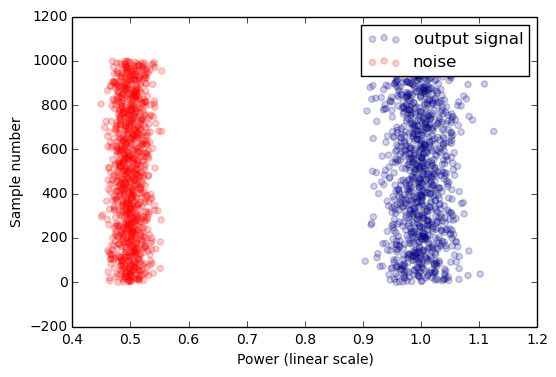

In [64]:
n_trials = 1000

noisy_signal_power_3db = []
noise_power_3db = []

for i in range(n_trials):
    noisy_signal_samples_3db, noise_samples_3db = generate_signal_noise(0)
    noisy_signal_power_3db.append(compute_power(noisy_signal_samples_3db))
    noise_power_3db.append(compute_power(noise_samples_3db))

plot_power_signal_noise(noisy_signal_power_3db,  noise_power_3db)


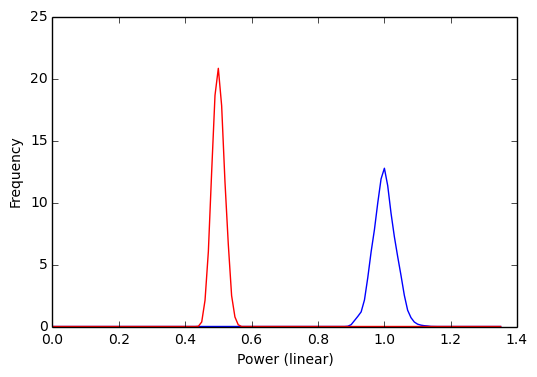

In [65]:
from scipy import stats
signal_power_density = stats.kde.gaussian_kde( np.array([noisy_signal_power_3db]) )
noise_power_density = stats.kde.gaussian_kde( np.array([noise_power_3db]) )
x = np.arange(0., 1.2*max(noisy_signal_power_3db), .01)
plt.plot(x, signal_power_density(x))
plt.plot(x, noise_power_density(x), color='r')
plt.xlabel("Power (linear)")
plt.ylabel("Frequency")


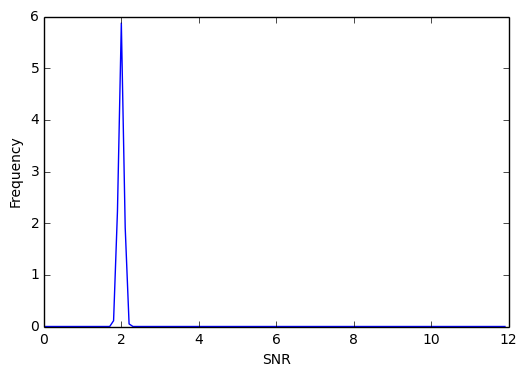

In [66]:
# Plot frequncy 
from scipy import stats
snr_density = stats.kde.gaussian_kde( np.array([noisy_signal_power_3db]) / np.array([noise_power_3db]) )
x = np.arange(0., 12, .1)
plt.plot(x, snr_density(x))
plt.xlabel("SNR")
plt.ylabel("Frequency")

#plt.hist((_/_2).T, bins=6)

# Try to understand how KDE normalized freq


## SNR of test case 2 is 0dB 

(0, 10)

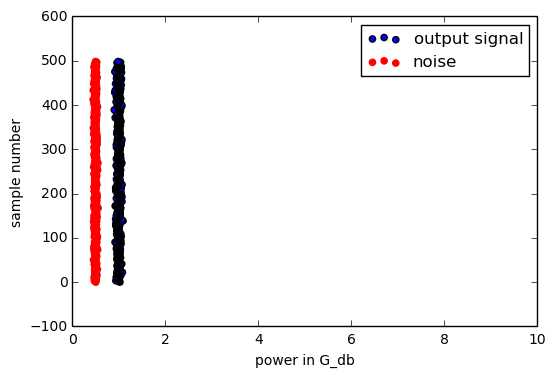

In [13]:
#snr_s_0,  snr_n_0 = plot_snr_syn(0,500)
snr_s_0,  snr_n_0 = synth_sP_nP(0,500)

plot_snr_syn(snr_s_0, snr_n_0)
plt.xlim(0,10)

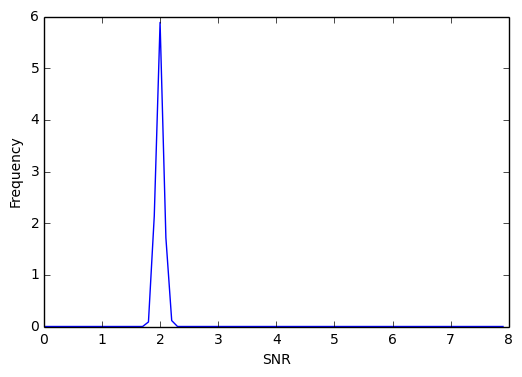

In [14]:
# Plot frequncy 
_= np.array([snr_s_0])
_2 = np.array([snr_n_0])

from scipy import stats
density = stats.kde.gaussian_kde(_/_2)
x = np.arange(0., 8, .1)
plt.plot(x, density(x))
plt.xlabel("SNR")
plt.ylabel("Frequency")

#plt.hist((_/_2).T, bins=6)

# Try to understand how KDE normalized freq

## SNR of test case 2 is -3dB 

In [ ]:
snr_s_10,  snr_n_10 = plt_snr(-3,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -5dB 

In [ ]:
snr_s_10,  snr_n_10 = plt_snr(-5,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -7dB 

In [ ]:
snr_s_10,  snr_n_10 = plt_snr(-7,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -9dB 

In [ ]:
snr_s_10,  snr_n_10 = plt_snr(-9,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## Need to retweak classifier since prediction is awful
##  the idea is the predictive accuracy of the classifier goes down as the snr goes up
## eventually will plot accuracy vs snr

In [ ]:
# Based on Professor Sundeep's Lab 7: SVM classifiers  

# Create training set and test set --> comprised of 500 samples where snr =4 and snr = -10
#X=np.empty(500)


#### ====> WORKING HERE
#snr_s_3,  snr_n_3 = synth_sP_nP(3,500)

X = np.array(snr_s_10[:125] + snr_s_3[:125] + snr_n_3[:125] + snr_n_10[:125])
y=np.concatenate([np.ones(125),np.ones(125),np.zeros(125),np.zeros(125)])
from sklearn import svm
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)

ntr = 400
nts = 100

Iperm = np.random.permutation(500)
Xtr = X[Iperm[:ntr]].reshape(-1,1)
ytr = y[Iperm[:ntr]].reshape(-1,1)
Xts = X[Iperm[ntr:ntr+nts]].reshape(-1,1)
yts = y[Iperm[ntr:ntr+nts]].reshape(-1,1)

svc.fit(Xtr,ytr)
# plot accuracy vs SNR

# predict accuracy
yhat1 = svc.predict(Xts)
acc = np.mean(yhat1 == yts)
print('Accuaracy = {0:f}'.format(acc))

In [ ]:
####### PERSONAL NOTES #############
# signal and noise 
# get snr
# create picture from 
# recreate picture to show energy dectetion doesn't always  work


# ML -- > samples from when user is on channel: output 
# no user plain noise --> 
 # show as snr goes down
    
# generate these values

#bunch of red blue; plot; find if linearly sepearble
# #see what happens as snr decreases; becomes harder and harder to 

# M2M4

#energy detection method with threshold for each 
# modulating by carrier means mult by sin,cos


### (to come) Theory behind Q-PSK and constellation
### (to come) Formula forAvg Power
 
> Some Notes

>*Explanation of Experiment to come*

>    Reading; seems relevant to what Fraida  was talking about; useful for writing "Q-PSK" theory section; avg energy theory; 
    http://web.stanford.edu/group/cioffi/doc/book/chap1.pdf
    
>    Will clean up "Generate Qpsk samples" code later

>   Just want to get working classifier

> Nxt part of expr will deal with using better data to make classifier better -- the non-random characteristics